In [1]:
using Revise
using Turing, MCMCChains
using XLSX
using DataFrames, TimeSeries
using StatsPlots
using LinearAlgebra
using CSV
using StatsBase
include("utils.jl")
include("financial_bvar_temp.jl")
using .FinancialBVAR

In [2]:
df = DataFrame(XLSX.readtable("usa_var_data.xlsx", "Data", infer_eltypes=true))
data_source = collapse(TimeArray(df; timestamp = :Date), Dates.quarter, last)

292×11 TimeArray{Float64, 2, Date, Matrix{Float64}} 1951-12-01 to 2024-07-01
┌────────────┬──────────┬───────────┬─────────────┬──────────┬────────┬─────────
│            │ Yeld_10Y │ Price_10Y │ Stock_Price │ Dividend │ E      │ CAPE   ⋯
├────────────┼──────────┼───────────┼─────────────┼──────────┼────────┼─────────
│ 1951-12-01 │  0.02513 │   104.098 │       24.19 │  1.41333 │   2.44 │ 12.527 ⋯
│ 1952-03-01 │  0.02505 │   104.824 │       23.74 │     1.43 │    2.4 │ 12.242 ⋯
│ 1952-06-01 │  0.02415 │   106.295 │       25.08 │     1.45 │   2.34 │ 12.669 ⋯
│ 1952-09-01 │  0.02685 │   104.468 │       24.26 │  1.43667 │   2.36 │ 12.131 ⋯
│ 1952-12-01 │  0.02547 │   106.402 │       26.18 │     1.41 │    2.4 │ 13.010 ⋯
│ 1953-03-01 │  0.02735 │   105.373 │       24.71 │  1.41333 │   2.43 │ 12.163 ⋯
│ 1953-06-01 │  0.02987 │    103.86 │       24.29 │     1.42 │   2.51 │ 11.750 ⋯
│ 1953-09-01 │  0.02636 │    107.81 │       23.97 │     1.43 │   2.55 │ 11.391 ⋯
│     ⋮      │    ⋮     │     ⋮ 

In [3]:
colnames(data_source)

11-element Vector{Symbol}:
 :Yeld_10Y
 :Price_10Y
 :Stock_Price
 :Dividend
 :E
 :CAPE
 :T_Bill
 :CPI
 :Dividend_Yeld
 :Total_Stock_2
 :Total_Stock

In [4]:
returns = percentchange(data_source[:Total_Stock, :Price_10Y], :log)
returns = merge(returns, log1p.(data_source[:T_Bill])./4)
cpi = percentchange(data_source[:CPI], :log)
real_returns = returns .- cpi
term = data_source[:Yeld_10Y] ./4 .- data_source[:T_Bill] ./4
dy = data_source[:Dividend_Yeld] #log.(data_source[:Dividend_Yeld])
data = merge(real_returns, dy, term, cpi)

291×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 1952-03-01 to 2024-07-01
┌────────────┬─────────────────┬───────────────┬─────────────┬───────────────┬──
│            │ Total_Stock_CPI │ Price_10Y_CPI │ T_Bill_CPI  │ Dividend_Yeld │ ⋯
├────────────┼─────────────────┼───────────────┼─────────────┼───────────────┼──
│ 1952-03-01 │      1.98335e-5 │     0.0107337 │  0.00772445 │     0.0602359 │ ⋯
│ 1952-06-01 │       0.0581411 │    0.00263202 │ -0.00708528 │      0.057815 │ ⋯
│ 1952-09-01 │      -0.0185027 │    -0.0173351 │  0.00423886 │     0.0592197 │ ⋯
│ 1952-12-01 │       0.0932838 │     0.0220972 │   0.0089235 │     0.0538579 │ ⋯
│ 1953-03-01 │      -0.0437093 │   -0.00972202 │  0.00497517 │     0.0571967 │ ⋯
│ 1953-06-01 │      -0.0100139 │    -0.0219485 │ -0.00227055 │     0.0584603 │ ⋯
│ 1953-09-01 │     -0.00574595 │     0.0298874 │ -0.00299956 │     0.0596579 │ ⋯
│ 1953-12-01 │        0.078226 │     0.0248173 │  0.00767892 │     0.0572141 │ ⋯
│     ⋮      │        ⋮        │ 

In [5]:
CSV.write("usa_data_transformed.csv", data)

"usa_data_transformed.csv"

In [6]:
start = Date(2005,03,01)
end_d = Date(2019, 12, 31)
s_data = to(from(data, start),end_d)

60×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 2005-03-01 to 2019-12-01
┌────────────┬─────────────────┬───────────────┬─────────────┬───────────────┬──
│            │ Total_Stock_CPI │ Price_10Y_CPI │ T_Bill_CPI  │ Dividend_Yeld │ ⋯
├────────────┼─────────────────┼───────────────┼─────────────┼───────────────┼──
│ 2005-03-01 │      -0.0304395 │    -0.0304179 │  -0.0134868 │     0.0175737 │ ⋯
│ 2005-06-01 │       0.0486321 │     0.0511387 │   0.0032143 │     0.0172716 │ ⋯
│ 2005-09-01 │      -0.0398841 │    -0.0416176 │  -0.0108536 │     0.0182221 │ ⋯
│ 2005-12-01 │       0.0790986 │     0.0116091 │   0.0140689 │     0.0175226 │ ⋯
│ 2006-03-01 │      0.00654065 │    -0.0418562 │  -0.0049802 │     0.0176628 │ ⋯
│ 2006-06-01 │      -0.0379358 │    -0.0197786 │  0.00182042 │     0.0187742 │ ⋯
│ 2006-09-01 │       0.0914919 │     0.0601759 │   0.0201336 │     0.0178674 │ ⋯
│ 2006-12-01 │       0.0449096 │    0.00276282 │  0.00879227 │     0.0176127 │ ⋯
│     ⋮      │        ⋮        │  

In [7]:
returns_summarystats(to(from(returns, start),end_d), 4)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock,0.133036,0.549192,0.0881747,0.257758,-1.01471,-1.45237,-0.0423317,0.226904,3.47566,0.66279,0.154288
Price_10Y,0.0796271,0.569087,0.0416632,0.131895,-0.286765,0.620588,-0.0573154,-0.0177436,1.23627,0.523228,0.0280389
T_Bill,0.00779959,0.0482186,0.012554,0.0211742,9.9995e-5,1.09796,0.000699755,0.964388,-0.125707,1.60957,0.00279608


In [8]:
returns_summarystats(s_data, 1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock_CPI,0.0649675,0.13347,0.0170079,0.0604197,-0.238141,-1.24956,-0.012061,0.206412,2.55315,0.261791,0.0342797
Price_10Y_CPI,0.0442219,0.167664,0.00538003,0.0351495,-0.0762726,0.815715,-0.02592,-0.0325918,1.86753,0.12166,0.00312517
T_Bill_CPI,0.00906845,0.025467,-0.00189726,0.00216889,-0.020792,0.694053,-0.00865384,0.0106209,0.882503,-0.209215,-0.00282525
Dividend_Yeld,0.0030386,0.0323637,0.0202015,0.0207695,0.0172716,2.52004,0.0183924,0.840397,6.81144,6.6483,0.0196554
Yeld_10Y_T_Bill,0.00267274,0.0095,0.00418417,0.0061875,-0.000725,-0.0829499,0.00235625,0.901587,-0.803255,1.5655,0.004425
CPI,0.00902944,0.0236495,0.00503576,0.00985738,-0.025392,-0.603923,0.00145653,-0.0271367,1.47285,0.557705,0.00457549


In [9]:
returns_summarystats(s_data, 4)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
Total_Stock_CPI,0.129935,0.533879,0.0680316,0.241679,-0.952565,-1.24956,-0.0482442,0.206412,2.55315,0.523582,0.137119
Price_10Y_CPI,0.0884439,0.670655,0.0215201,0.140598,-0.305091,0.815715,-0.10368,-0.0325918,1.86753,0.24332,0.0125007
T_Bill_CPI,0.0181369,0.101868,-0.00758902,0.00867556,-0.083168,0.694053,-0.0346154,0.0106209,0.882503,-0.41843,-0.011301
Dividend_Yeld,0.0060772,0.129455,0.0808062,0.0830779,0.0690863,2.52004,0.0735696,0.840397,6.81144,13.2966,0.0786215
Yeld_10Y_T_Bill,0.00534548,0.038,0.0167367,0.02475,-0.0029,-0.0829499,0.009425,0.901587,-0.803255,3.13099,0.0177
CPI,0.0180589,0.0945979,0.020143,0.0394295,-0.101568,-0.603923,0.00582611,-0.0271367,1.47285,1.11541,0.018302


In [10]:
#returns = percentchange(data_source[:Total_Stock, :Price_10Y], :log)
returns1y = from(to(percentchange(collapse(data_source[:Total_Stock, :Price_10Y],year, last), :log),end_d),start)
returns_summarystats(returns3y,1)

UndefVarError: UndefVarError: `returns3y` not defined

In [11]:
returns1y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],4) ./1
returns3y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],12) ./3
returns5y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],20) ./5
returns10y = moving(sum,s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI],40) ./10
cum_returns = merge(TimeSeries.rename!(returns1y, [:RealStock1y, :RealBonds1y, :RealTBill1y]), 
                    TimeSeries.rename!(returns3y, [:RealStock3y, :RealBonds3y, :RealTBill3y]), 
                    TimeSeries.rename!(returns5y, [:RealStock5y, :RealBonds5y, :RealTBill5y]),
                    TimeSeries.rename!(returns10y, [:RealStock10y, :RealBonds10y, :RealTBill10y]))
returns_summarystats(expm1.(cum_returns),1)

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
RealStock1y,0.0797301,0.249971,0.100797,0.145202,-0.0619106,-0.219332,0.0644004,0.390154,-0.202281,1.26423,0.0935139
RealBonds1y,0.0629584,0.134716,0.0205006,0.0656733,-0.0686739,0.124988,-0.0298997,0.668053,-1.20131,0.325622,0.0240275
RealTBill1y,0.00775009,0.00466225,-0.00645205,0.00124459,-0.021074,0.00330104,-0.0120181,0.710696,-1.14393,-0.832513,-0.00741696
RealStock3y,0.0251101,0.170972,0.113346,0.115557,0.0830609,1.01029,0.0991255,0.686876,0.199523,4.51397,0.108927
RealBonds3y,0.0197911,0.044101,0.00481437,0.0195163,-0.0267982,0.353804,-0.0110897,0.673669,-0.729686,0.243259,0.000525581
RealTBill3y,0.00258979,-0.00348879,-0.0092176,-0.00870969,-0.0147434,0.0511985,-0.0104051,0.44348,0.315756,-3.55921,-0.00896623
RealStock5y,0.0178266,0.143472,0.114122,0.129711,0.0797366,-0.153572,0.100655,0.59925,-0.973192,6.40176,0.11602
RealBonds5y,0.0158227,0.0402395,0.0132394,0.0210669,-0.00847782,0.464498,-0.000500067,0.671255,-0.940835,0.836738,0.0132324
RealTBill5y,0.00314395,-0.00565486,-0.0112197,-0.0100645,-0.0173322,-0.0428557,-0.0125176,0.861357,-0.4762,-3.56867,-0.0112185
RealStock10y,0.0302373,0.133104,0.0769565,0.11056,0.0444601,0.699757,0.0542578,0.881245,-1.16493,2.54509,0.0591631


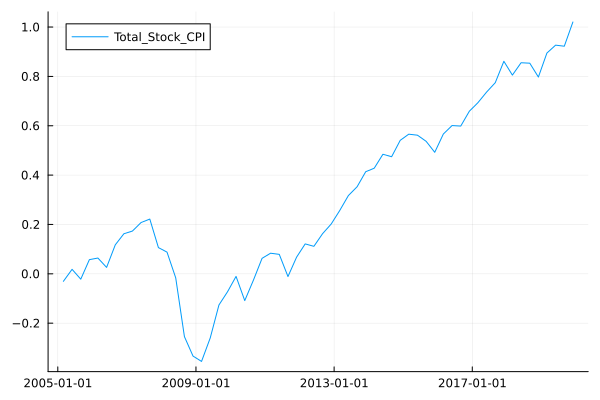

In [12]:
plot(cumsum(s_data[:Total_Stock_CPI]))

In [13]:
vmodel = VARModel(s_data)
model_summary(vmodel)

,const,Total_Stock_CPI,Price_10Y_CPI,T_Bill_CPI,Dividend_Yeld,Yeld_10Y_T_Bill,CPI,std
Total_Stock_CPI,0.0234,0.2147,-0.2286,-5.8033,2.8524,-9.9827,-6.759,0.0633
Price_10Y_CPI,0.0701,-0.373,-0.1578,3.441,-4.7073,7.6653,2.3888,0.038
T_Bill_CPI,-0.0006,-0.0563,-0.0581,0.5433,-0.0456,-0.0842,0.4855,0.0082
Dividend_Yeld,0.005,-0.0113,0.0026,0.0314,0.7279,0.1293,0.0408,0.0015
Yeld_10Y_T_Bill,-0.0032,0.0048,0.004,-0.0215,0.1763,0.8473,0.0163,0.001
CPI,0.0016,0.0609,0.0572,0.3946,0.0097,0.0368,0.4455,0.0082


,Total_Stock_CPI,Price_10Y_CPI,T_Bill_CPI,Dividend_Yeld,Yeld_10Y_T_Bill,CPI
Total_Stock_CPI,1.0,-0.16,-0.07,-0.96,0.01,0.09
Price_10Y_CPI,-0.16,1.0,0.49,0.23,-0.62,-0.52
T_Bill_CPI,-0.07,0.49,1.0,0.25,-0.27,-0.99
Dividend_Yeld,-0.96,0.23,0.25,1.0,-0.03,-0.26
Yeld_10Y_T_Bill,0.01,-0.62,-0.27,-0.03,1.0,0.22
CPI,0.09,-0.52,-0.99,-0.26,0.22,1.0


In [14]:
bmodel = NormalWishartBVAR(s_data)
sample_posterior!(bmodel,10000, 2000)
posterior_summary(bmodel)

"Total_Stock_CPI coefficients"

Quantiles
       parameters       2.5%      25.0%      50.0%     75.0%     97.5% 
           Symbol    Float64    Float64    Float64   Float64   Float64 

            const    -0.1609    -0.0392     0.0220    0.0828    0.2051
  Total_Stock_CPI    -0.1132     0.1044     0.2167    0.3233    0.5428
    Price_10Y_CPI    -0.7436    -0.4071    -0.2303   -0.0560    0.2886
       T_Bill_CPI   -13.8164    -8.4190    -5.7757   -3.1719    2.0017
    Dividend_Yeld    -4.7243     0.3862     2.9759    5.4880   10.6837
  Yeld_10Y_T_Bill   -21.5298   -13.8357   -10.0678   -6.2484    1.0473
              CPI   -14.9647    -9.4330    -6.7334   -3.9840    1.4592


"Price_10Y_CPI coefficients"

Quantiles
       parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol   Float64   Float64   Float64   Float64   Float64 

            const   -0.0377    0.0333    0.0688    0.1056    0.1797
  Total_Stock_CPI   -0.5679   -0.4395   -0.3725   -0.3068   -0.1750
    Price_10Y_CPI   -0.4702   -0.2648   -0.1562   -0.0533    0.1582
       T_Bill_CPI   -1.3016    1.8910    3.4699    5.0483    8.0989
    Dividend_Yeld   -9.3175   -6.2162   -4.6822   -3.1509   -0.1213
  Yeld_10Y_T_Bill    0.8220    5.4604    7.6932    9.9460   14.2516
              CPI   -2.4404    0.7588    2.4370    4.0490    7.2794


"T_Bill_CPI coefficients"

Quantiles
       parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol   Float64   Float64   Float64   Float64   Float64 

            const   -0.0232   -0.0085   -0.0007    0.0071    0.0225
  Total_Stock_CPI   -0.0977   -0.0708   -0.0563   -0.0419   -0.0131
    Price_10Y_CPI   -0.1262   -0.0805   -0.0578   -0.0357    0.0079
       T_Bill_CPI   -0.4299    0.2128    0.5453    0.8899    1.5572
    Dividend_Yeld   -1.0324   -0.3745   -0.0472    0.2866    0.9353
  Yeld_10Y_T_Bill   -1.4983   -0.5681   -0.0753    0.4043    1.3343
              CPI   -0.5558    0.1373    0.4907    0.8374    1.5414


"Dividend_Yeld coefficients"

Quantiles
       parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol   Float64   Float64   Float64   Float64   Float64 

            const    0.0007    0.0036    0.0050    0.0064    0.0093
  Total_Stock_CPI   -0.0190   -0.0139   -0.0113   -0.0087   -0.0035
    Price_10Y_CPI   -0.0098   -0.0016    0.0026    0.0068    0.0150
       T_Bill_CPI   -0.1576   -0.0324    0.0312    0.0941    0.2180
    Dividend_Yeld    0.5443    0.6646    0.7258    0.7880    0.9072
  Yeld_10Y_T_Bill   -0.1316    0.0402    0.1319    0.2204    0.3969
              CPI   -0.1553   -0.0240    0.0407    0.1056    0.2345


"Yeld_10Y_T_Bill coefficients"

Quantiles
       parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol   Float64   Float64   Float64   Float64   Float64 

            const   -0.0062   -0.0042   -0.0032   -0.0022   -0.0002
  Total_Stock_CPI   -0.0006    0.0029    0.0048    0.0066    0.0101
    Price_10Y_CPI   -0.0046    0.0011    0.0041    0.0069    0.0126
       T_Bill_CPI   -0.1483   -0.0648   -0.0224    0.0213    0.1063
    Dividend_Yeld    0.0506    0.1327    0.1752    0.2173    0.3041
  Yeld_10Y_T_Bill    0.6658    0.7847    0.8470    0.9096    1.0324
              CPI   -0.1166   -0.0299    0.0159    0.0610    0.1487


"CPI coefficients"

Quantiles
       parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
           Symbol   Float64   Float64   Float64   Float64   Float64 

            const   -0.0218   -0.0062    0.0016    0.0097    0.0245
  Total_Stock_CPI    0.0173    0.0462    0.0610    0.0755    0.1030
    Price_10Y_CPI   -0.0092    0.0344    0.0571    0.0801    0.1258
       T_Bill_CPI   -0.6303    0.0450    0.3911    0.7297    1.3761
    Dividend_Yeld   -0.9717   -0.3222    0.0125    0.3345    1.0113
  Yeld_10Y_T_Bill   -1.4007   -0.4527    0.0264    0.5233    1.4557
              CPI   -0.6226    0.0841    0.4388    0.7942    1.4927


"correlation matrix"

Quantiles
                       parameters      2.5%     25.0%     50.0%     75.0%      ⋯
                           Symbol   Float64   Float64   Float64   Float64   Fl ⋯

  Total_Stock_CPI_Total_Stock_CPI    0.0555    0.0625    0.0669    0.0717    0 ⋯
    Total_Stock_CPI_Price_10Y_CPI   -0.4216   -0.2541   -0.1596   -0.0628    0 ⋯
       Total_Stock_CPI_T_Bill_CPI   -0.3422   -0.1696   -0.0735    0.0254    0 ⋯
    Total_Stock_CPI_Dividend_Yeld   -0.9755   -0.9647   -0.9571   -0.9483   -0 ⋯
  Total_Stock_CPI_Yeld_10Y_T_Bill   -0.2737   -0.0881    0.0102    0.1060    0 ⋯
              Total_Stock_CPI_CPI   -0.1991   -0.0084    0.0900    0.1858    0 ⋯
    Price_10Y_CPI_Total_Stock_CPI   -0.4216   -0.2541   -0.1596   -0.0628    0 ⋯
      Price_10Y_CPI_Price_10Y_CPI    0.0333    0.0375    0.0402    0.0431    0 ⋯
         Price_10Y_CPI_T_Bill_CPI    0.2450    0.4124    0.4897    0.5618    0 ⋯
      Price_10Y_CPI_Dividend_Yeld   -0.0435    0.1403    0.2333    0.3254    0 ⋯
    Price_10Y_CPI

In [15]:
assets_names = colnames(s_data)
scenarios = simulate(vmodel,60)

for n in 1:6
    s_ann = annualise(scenarios[n,:,2:end],4)
    print_percentiles(s_ann,[0.05, 0.25, 0.5, 0.75, 0.95], string(assets_names[n]))
end

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.0253658,-0.10599,-0.115737,-0.138662,-0.148629,-0.158056,-0.168316,-0.164071,-0.16943,-0.167825,-0.163912,-0.16957,-0.162879,-0.163239,-0.161434
0.25,0.101939,0.0365308,0.0223336,0.0101484,-0.00242175,-0.0123917,-0.0185833,-0.0182204,-0.0226834,-0.0199703,-0.0201191,-0.0192154,-0.0198652,-0.012989,-0.0155566
0.5,0.191535,0.13589,0.123674,0.10612,0.100337,0.0877109,0.0863612,0.081262,0.0800092,0.0833043,0.0815111,0.0828236,0.0825672,0.0882262,0.0876291
0.75,0.28029,0.234519,0.223173,0.207647,0.199402,0.188651,0.187227,0.183103,0.182172,0.18394,0.185961,0.186309,0.187919,0.192207,0.187031
0.95,0.41057,0.374339,0.370078,0.356329,0.341705,0.33389,0.33383,0.326996,0.328091,0.329299,0.3297,0.338977,0.334132,0.338098,0.342337


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.161084,-0.149617,-0.148563,-0.143572,-0.134321,-0.127347,-0.129173,-0.122675,-0.124604,-0.123906,-0.126724,-0.128348,-0.124657,-0.128973,-0.12824
0.25,-0.0993356,-0.0725161,-0.069503,-0.0627445,-0.0563693,-0.0489047,-0.0483388,-0.045606,-0.0455599,-0.0451731,-0.0443285,-0.0449451,-0.0446714,-0.0471136,-0.0444667
0.5,-0.0563358,-0.0180882,-0.0145275,-0.00743567,-0.000337758,0.00541991,0.00564328,0.00995517,0.0118854,0.0112263,0.0113237,0.0119964,0.0105258,0.0083842,0.0114899
0.75,-0.0120774,0.0364163,0.041301,0.0486222,0.0544357,0.0590731,0.061694,0.0654614,0.0657747,0.0653281,0.0672588,0.0671896,0.0668355,0.063411,0.0663937
0.95,0.0472521,0.113053,0.118568,0.126664,0.134508,0.141671,0.143322,0.144246,0.149027,0.14578,0.145595,0.14782,0.146266,0.1449,0.148312


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.0349415,-0.0314855,-0.0303468,-0.0303769,-0.0302179,-0.0316768,-0.0322632,-0.0338082,-0.0344655,-0.0356939,-0.0360917,-0.0365168,-0.0364993,-0.0370855,-0.0369583
0.25,-0.018946,-0.0141639,-0.0126435,-0.0125251,-0.0127763,-0.0128237,-0.0138855,-0.014504,-0.0151058,-0.0156607,-0.0164304,-0.0170387,-0.0173132,-0.017469,-0.0176321
0.5,-0.0076372,-0.00213848,-0.000726622,-0.000288566,-7.49753e-5,5.98755e-5,-0.000693424,-0.00117948,-0.00172584,-0.00218153,-0.00273785,-0.00336779,-0.00370607,-0.00410485,-0.00422352
0.75,0.00324041,0.00982548,0.0115405,0.0121811,0.012684,0.0128909,0.012512,0.0118851,0.0117334,0.0109897,0.0105657,0.00996498,0.00980277,0.00931425,0.00916673
0.95,0.0190969,0.0268012,0.0295802,0.0304656,0.0313795,0.0317934,0.0310895,0.0314027,0.0315151,0.0307564,0.0299454,0.0292037,0.0297395,0.0283568,0.0282744


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,0.0552703,0.053082,0.0537794,0.0545064,0.0558387,0.0561995,0.0570926,0.0574145,0.0583714,0.0583234,0.0586179,0.0585746,0.0588345,0.0585842,0.0579009
0.25,0.0631059,0.063485,0.0649349,0.0660664,0.0669562,0.0680896,0.0688244,0.0695389,0.0700387,0.0700669,0.0699988,0.0702549,0.0704019,0.070113,0.0700607
0.5,0.0686047,0.0708583,0.0726691,0.0741311,0.0749455,0.0763167,0.077092,0.0775344,0.0780869,0.0783345,0.0782563,0.0783117,0.0784984,0.0782901,0.0783281
0.75,0.0739016,0.0785244,0.0804079,0.0819695,0.0831637,0.0844032,0.0851428,0.0856347,0.0859878,0.0864176,0.0863928,0.0865196,0.0865504,0.0862589,0.0865423
0.95,0.081799,0.0887133,0.0911788,0.0933014,0.0946458,0.0956197,0.096685,0.0973998,0.0979875,0.098379,0.0983009,0.0984753,0.0981864,0.0980368,0.0984033


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.0033486,-0.00869467,-0.0113732,-0.0123939,-0.0119917,-0.0118884,-0.0114346,-0.0109617,-0.00983182,-0.00915861,-0.00857399,-0.0082667,-0.00804929,-0.00796091,-0.00816151
0.25,0.00122911,-0.00122549,-0.00202583,-0.00197007,-0.00108726,-0.000273007,0.000953564,0.0013582,0.00208818,0.00286847,0.00310826,0.00363853,0.00393964,0.00389302,0.00399669
0.5,0.00451574,0.0040764,0.00471756,0.00573841,0.00674215,0.00781873,0.00903105,0.00992693,0.0105557,0.010989,0.011577,0.0118836,0.0120451,0.0123446,0.0123617
0.75,0.00760024,0.00924228,0.0111988,0.0129398,0.0147184,0.016176,0.0170848,0.0182385,0.019005,0.0194811,0.0200342,0.0202056,0.0203373,0.0204649,0.0207204
0.95,0.0122314,0.0166601,0.0207004,0.0231756,0.0254486,0.0276313,0.0291905,0.0302719,0.031096,0.0318247,0.0322353,0.0325412,0.0324229,0.0328131,0.0328553


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.000834625,-0.00485666,-0.00480655,-0.00538016,-0.00517059,-0.00636739,-0.00696982,-0.00732641,-0.00808726,-0.00737174,-0.00825926,-0.00858625,-0.00908891,-0.00795933,-0.0086055
0.25,0.0158879,0.0123332,0.0126939,0.0123827,0.012145,0.0112646,0.0111941,0.0111537,0.0101426,0.0101697,0.00963825,0.00949322,0.00940844,0.00933014,0.00890695
0.5,0.0271382,0.0244189,0.024258,0.0249625,0.0246122,0.0239045,0.0237441,0.0232827,0.0226526,0.02247,0.0222168,0.0222952,0.0219916,0.0218121,0.0219771
0.75,0.0385106,0.0367481,0.0366499,0.0371947,0.0367691,0.036344,0.0361774,0.0355432,0.0351933,0.0351656,0.0349105,0.0347199,0.03469,0.0344981,0.0345048
0.95,0.0552379,0.0547597,0.0544358,0.0549371,0.05479,0.053736,0.0537548,0.0533388,0.0533748,0.0526916,0.0529356,0.0526486,0.0515523,0.0524486,0.0520941


In [16]:
scenarios_b = simulate(bmodel,60, 10)
for n in 1:6
    s_ann = annualise(scenarios_b[n,:,2:end],4)
    print_percentiles(s_ann,[0.02, 0.25, 0.5, 0.75, 0.98], string(assets_names[n]))
end

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.444165,-1.15787,-1.40731,-1.62161,-1.84633,-2.05511,-2.2629,-2.52813,-2.73526,-3.07512,-3.40358,-3.74822,-4.27276,-4.87998,-5.5372
0.25,0.0169554,-0.161059,-0.209877,-0.241671,-0.269019,-0.28496,-0.300466,-0.312444,-0.319113,-0.330598,-0.337372,-0.336867,-0.345159,-0.347694,-0.354426
0.5,0.170204,0.127038,0.123851,0.114824,0.110262,0.108737,0.104341,0.103539,0.104369,0.105678,0.106609,0.108323,0.108019,0.109383,0.111581
0.75,0.352479,0.445165,0.485536,0.503372,0.517786,0.530555,0.53995,0.552841,0.558558,0.573403,0.584644,0.596346,0.606448,0.614215,0.624763
0.98,0.944797,1.56415,1.84521,2.11233,2.42322,2.74827,3.19062,3.68818,4.34063,5.11161,6.15833,7.38096,8.8806,10.6523,12.9876


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.496509,-0.742316,-0.799263,-0.822092,-0.851785,-0.880094,-0.918203,-0.956819,-0.992332,-1.0395,-1.1065,-1.17863,-1.30963,-1.44131,-1.61629
0.25,-0.163792,-0.207762,-0.223715,-0.229605,-0.233084,-0.233914,-0.237206,-0.240381,-0.242132,-0.245129,-0.249108,-0.255334,-0.25789,-0.262047,-0.267661
0.5,-0.0486453,-0.0145636,-0.0109644,-0.00569991,0.000270556,0.000404001,0.00430301,0.00529844,0.00573,0.00470072,0.00470981,0.00350643,0.00357168,0.00309151,0.00228746
0.75,0.0576089,0.174956,0.196388,0.212596,0.225665,0.233242,0.243139,0.248648,0.249306,0.25361,0.257538,0.257513,0.263185,0.263587,0.265703
0.98,0.347901,0.703743,0.757509,0.798907,0.842543,0.874981,0.90141,0.933236,0.97163,1.00766,1.06274,1.10809,1.18719,1.27355,1.38568


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.076586,-0.124424,-0.148809,-0.171876,-0.196448,-0.223975,-0.257666,-0.297223,-0.339731,-0.388101,-0.450757,-0.521017,-0.605633,-0.691674,-0.808159
0.25,-0.0238267,-0.0298823,-0.0349559,-0.0385068,-0.0422214,-0.0454694,-0.0487921,-0.0517708,-0.0538521,-0.0561593,-0.0588527,-0.0604764,-0.0618273,-0.0631779,-0.0641656
0.5,-0.00637036,-0.00143202,-0.00100328,-0.000363852,-0.000330406,-0.000609245,-0.00143309,-0.00150101,-0.00195919,-0.00239401,-0.00259103,-0.0029579,-0.00327058,-0.00346644,-0.00335603
0.75,0.0105825,0.0274576,0.0345244,0.0397753,0.0440497,0.0478932,0.0507114,0.0530953,0.0549382,0.0570973,0.0589539,0.0600269,0.0607015,0.0617759,0.0631571
0.98,0.0554102,0.118489,0.149339,0.180158,0.215644,0.26037,0.304764,0.362313,0.430234,0.509988,0.617921,0.734591,0.883967,1.06664,1.28534


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,0.0220063,-0.0287697,-0.0726099,-0.112017,-0.153521,-0.201006,-0.260599,-0.325068,-0.403818,-0.502636,-0.632452,-0.780725,-0.96869,-1.20804,-1.49213
0.25,0.0554663,0.0482508,0.0434564,0.0402199,0.0383138,0.0365614,0.0349799,0.0331861,0.0323963,0.0313807,0.0302529,0.0295191,0.0285975,0.0271036,0.0261131
0.5,0.068757,0.0721329,0.073408,0.0743,0.0748072,0.0755649,0.075913,0.0760128,0.0763965,0.076299,0.0766119,0.0764065,0.0766067,0.0763801,0.0765072
0.75,0.0817187,0.0941126,0.100878,0.104722,0.108013,0.110569,0.112527,0.114189,0.115691,0.116726,0.117698,0.118565,0.119236,0.119762,0.12035
0.98,0.112451,0.158011,0.193327,0.225419,0.255637,0.28682,0.317064,0.352064,0.39192,0.429796,0.475591,0.53148,0.58935,0.668428,0.766045


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.0444904,-0.0831806,-0.122628,-0.16838,-0.220766,-0.282668,-0.351923,-0.433888,-0.536852,-0.65744,-0.804401,-0.992626,-1.22747,-1.5289,-1.89135
0.25,-0.00987283,-0.0199004,-0.0262456,-0.0310657,-0.0351275,-0.038643,-0.040753,-0.0426924,-0.0442618,-0.0457155,-0.0469763,-0.0483927,-0.0493265,-0.0504599,-0.0515141
0.5,0.00457549,0.00416942,0.00464074,0.00571277,0.0064587,0.00753874,0.00813257,0.0088861,0.00928592,0.00965924,0.00996542,0.0100964,0.0101014,0.0102689,0.010283
0.75,0.0188423,0.0273071,0.0343318,0.0396742,0.0445673,0.0482878,0.0522434,0.0547253,0.0566056,0.0584517,0.0602447,0.0618623,0.0629338,0.0633886,0.0644686
0.98,0.0515831,0.0842201,0.113767,0.147619,0.184512,0.22392,0.264462,0.310138,0.359398,0.415057,0.47636,0.550812,0.631052,0.729123,0.842706


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.02,-0.0335133,-0.078506,-0.102085,-0.123055,-0.145741,-0.171793,-0.197676,-0.229624,-0.265289,-0.30673,-0.352037,-0.400568,-0.464185,-0.541273,-0.638211
0.25,0.0126647,0.00147227,-0.00249163,-0.0052988,-0.00815393,-0.0103805,-0.0122294,-0.0140786,-0.0161305,-0.0169404,-0.0187474,-0.0197637,-0.0202008,-0.0210476,-0.0221427
0.5,0.0273191,0.0240819,0.0243064,0.0241734,0.0237492,0.0235528,0.0234983,0.0231693,0.0229426,0.0229034,0.0226211,0.0225353,0.0224928,0.0222662,0.0222856
0.75,0.0418957,0.0477315,0.0531262,0.0563842,0.0587275,0.0605674,0.0628085,0.0646386,0.0655514,0.0664566,0.067473,0.0679915,0.0691655,0.0699819,0.0712698
0.98,0.0816415,0.128852,0.161006,0.188944,0.220521,0.2549,0.295913,0.344356,0.399431,0.467924,0.55293,0.653572,0.774456,0.941007,1.13757


In [17]:
# annualised compounded returns for 1, 5, 10, 15 years
for n in 1:3
    cum_ret = cumsum(scenarios[n,:,2:end]; dims=2)
    print_percentiles(expm1.(cum_ret[:,[4,20,40,60]] ./ [1 5 10 15]),[.02, .1, .25, .5, .75, .9, .98], string(assets_names[n]))    
end

,1,2,3,4
0.02,-0.0761081,0.000684786,0.00980555,0.0217853
0.1,0.0235796,0.0497007,0.0468437,0.0528143
0.25,0.107316,0.0924822,0.0777264,0.0770021
0.5,0.211108,0.14057,0.11348,0.105907
0.75,0.323514,0.192559,0.149056,0.133937
0.9,0.436537,0.239358,0.182923,0.159886
0.98,0.591118,0.302017,0.228628,0.193898


,1,2,3,4
0.02,-0.169633,-0.0540809,-0.0274231,-0.0159169
0.1,-0.129365,-0.0407461,-0.0189755,-0.0100932
0.25,-0.0945612,-0.030726,-0.0126616,-0.00538499
0.5,-0.0547783,-0.0189194,-0.00529114,-0.000151693
0.75,-0.0120048,-0.00753019,0.00199053,0.00525733
0.9,0.026274,0.00278401,0.00854037,0.0101238
0.98,0.0765848,0.017272,0.0175588,0.0163544


,1,2,3,4
0.02,-0.0409148,-0.0197846,-0.0178163,-0.0172989
0.1,-0.0280732,-0.0132691,-0.0118698,-0.0117915
0.25,-0.0187677,-0.00808531,-0.00700184,-0.00733834
0.5,-0.00760811,-0.00224729,-0.00172917,-0.002429
0.75,0.00324566,0.00378209,0.00380544,0.00280694
0.9,0.0130978,0.00917415,0.00880914,0.00729704
0.98,0.0263516,0.0163763,0.0149075,0.0128613


In [18]:
for n in 1:3
    s_ann = expm1.(annualise(scenarios[n,:,2:end], 12))
    print_percentiles(s_ann,[0.02, 0.25, 0.5, 0.75, 0.98], string(assets_names[n]))
end


,1,2,3,4,5
0.02,-0.0139127,-0.207047,-0.259578,-0.270202,-0.257955
0.25,0.341164,0.129372,0.0685543,0.0688913,0.0776636
0.5,0.566999,0.340016,0.276537,0.28188,0.297934
0.75,0.843955,0.598457,0.532253,0.534962,0.565619
0.98,1.53598,1.28824,1.1716,1.24212,1.27411


,1,2,3,4,5
0.02,-0.217461,-0.195634,-0.176867,-0.17432,-0.17717
0.25,-0.130754,-0.0716955,-0.0455129,-0.0405837,-0.0448179
0.5,-0.0840149,-0.00250559,0.0282932,0.0321037,0.0307441
0.75,-0.0358113,0.0701021,0.105439,0.110161,0.110386
0.98,0.0669397,0.238748,0.282928,0.30049,0.293442


,1,2,3,4,5
0.02,-0.0703043,-0.0740288,-0.0824633,-0.0906326,-0.0934449
0.25,-0.0302728,-0.0243089,-0.0304747,-0.0355911,-0.0398212
0.5,-0.0108859,4.24802e-5,-0.00347189,-0.00869611,-0.0120785
0.75,0.00938579,0.025351,0.0241781,0.0190746,0.0160431
0.98,0.0538885,0.0802634,0.0842717,0.079194,0.0758946


In [19]:
scenarios[1,:,14:26]

10000×13 Matrix{Float64}:
  0.0123404   -0.0174293    0.1928       …   0.114771   -0.0117162
  0.0322795    0.0865139   -0.0143444        0.0193518   0.0305717
  0.0375407    0.106925    -0.0882407        0.0709556   0.0912162
  0.0206687    0.0685714   -0.0761909        0.0884719  -0.0287959
  0.0692218    0.0781421   -0.047132         0.0257682   0.0653401
 -0.0318455    0.0353146    0.00854813   …   0.0527111   0.1132
  0.0342098    0.0966271    0.0057149        0.020083    0.00201951
 -0.066932     0.189871     0.0381981        0.0146389   0.0287736
  0.00162967  -0.0965201    0.138429         0.0464105   0.0535739
  0.0919005    0.0343249    0.013749         0.0484896  -0.0214579
  ⋮                                      ⋱              
 -0.0370116    0.0339156   -0.0142891       -0.0601796  -0.0631638
 -0.00282093   0.0147992    0.0365961        0.0212384   0.191879
 -0.00962075  -0.0321008    0.0225318       -0.0161391   0.0831701
 -0.0945665    0.00050865   0.00291022       0.06

In [20]:
quantile(sum(scenarios[1,:,14:26], dims=2),[0.02, 0.25, 0.5, 0.75, 0.98])

5-element Vector{Float64}:
 -0.23348483237153672
  0.13432711606709216
  0.3150275041837282
  0.4993354394232774
  0.8705151725245633

In [21]:
quantile(sum(scenarios[2,:,14:26], dims=2),[0.02, 0.25, 0.5, 0.75, 0.98])

5-element Vector{Float64}:
 -0.22342275098666833
 -0.07466616914527903
  0.0009912811553626655
  0.0719051706830492
  0.22003089624874034

In [22]:
s_data

60×6 TimeArray{Float64, 2, Date, Matrix{Float64}} 2005-03-01 to 2019-12-01
┌────────────┬─────────────────┬───────────────┬─────────────┬───────────────┬──
│            │ Total_Stock_CPI │ Price_10Y_CPI │ T_Bill_CPI  │ Dividend_Yeld │ ⋯
├────────────┼─────────────────┼───────────────┼─────────────┼───────────────┼──
│ 2005-03-01 │      -0.0304395 │    -0.0304179 │  -0.0134868 │     0.0175737 │ ⋯
│ 2005-06-01 │       0.0486321 │     0.0511387 │   0.0032143 │     0.0172716 │ ⋯
│ 2005-09-01 │      -0.0398841 │    -0.0416176 │  -0.0108536 │     0.0182221 │ ⋯
│ 2005-12-01 │       0.0790986 │     0.0116091 │   0.0140689 │     0.0175226 │ ⋯
│ 2006-03-01 │      0.00654065 │    -0.0418562 │  -0.0049802 │     0.0176628 │ ⋯
│ 2006-06-01 │      -0.0379358 │    -0.0197786 │  0.00182042 │     0.0187742 │ ⋯
│ 2006-09-01 │       0.0914919 │     0.0601759 │   0.0201336 │     0.0178674 │ ⋯
│ 2006-12-01 │       0.0449096 │    0.00276282 │  0.00879227 │     0.0176127 │ ⋯
│     ⋮      │        ⋮        │  

In [23]:
 cov_m = cov(values(s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI])) 
 mu = mean(values(s_data[:Total_Stock_CPI, :Price_10Y_CPI, :T_Bill_CPI]), dims=1) 

1×3 Matrix{Float64}:
 0.0170079  0.00538003  -0.00189726

In [24]:
using Distributions
scenarios_n = zeros(3,100_000,60)

for t in 1:60
    scenarios_n[:,:,t] = rand(MvNormal(vec(mu), cov_m), 100_000)
end
scenarios_n

3×100000×60 Array{Float64, 3}:
[:, :, 1] =
  0.0711445   0.0729526    0.0547868   …  0.0619109    0.014048     0.0338456
 -0.0525411   0.0116346    0.0328312      0.0330124   -0.0165097   -0.006289
 -8.33106e-5  0.00313238  -0.00659068     0.00678543  -0.00139921  -0.0207288

[:, :, 2] =
  0.122312     0.0598464   -0.0230847   …   0.00217167  -0.0877946
 -0.0647035   -0.0040101   -0.00488574      0.0075388   -0.0370223
 -0.00915749  -0.00143219  -0.00655173     -0.00229455   0.00307846

[:, :, 3] =
 -0.11592     -0.0413472    0.0555364   …   0.0866749   0.0312756
 -0.0385226    0.0442117    0.00268818      0.00281439  0.11035
 -0.00236588  -0.00262968  -0.00506375     -0.00163546  0.0229453

;;; … 

[:, :, 58] =
 -0.149341    -0.00249422  -0.00809622  …   0.0903117  -0.0666422
  0.0557961   -0.0241364   -0.0601555      -0.0204913   0.0421956
 -0.00118348  -0.00144968  -0.00149046      0.0087702   0.00906639

[:, :, 59] =
 0.00477439   0.052594     0.12017     …   0.157251   -0.00850821

In [27]:
for n in 1:3
    s_ann = expm1.(annualise(scenarios[n,:,2:end], 12))
    print_percentiles(s_ann,[0.02, 0.25, 0.5, 0.75, 0.98], string(assets_names[n]))
end

,1,2,3,4,5
0.02,-0.0139127,-0.207047,-0.259578,-0.270202,-0.257955
0.25,0.341164,0.129372,0.0685543,0.0688913,0.0776636
0.5,0.566999,0.340016,0.276537,0.28188,0.297934
0.75,0.843955,0.598457,0.532253,0.534962,0.565619
0.98,1.53598,1.28824,1.1716,1.24212,1.27411


,1,2,3,4,5
0.02,-0.217461,-0.195634,-0.176867,-0.17432,-0.17717
0.25,-0.130754,-0.0716955,-0.0455129,-0.0405837,-0.0448179
0.5,-0.0840149,-0.00250559,0.0282932,0.0321037,0.0307441
0.75,-0.0358113,0.0701021,0.105439,0.110161,0.110386
0.98,0.0669397,0.238748,0.282928,0.30049,0.293442


,1,2,3,4,5
0.02,-0.0703043,-0.0740288,-0.0824633,-0.0906326,-0.0934449
0.25,-0.0302728,-0.0243089,-0.0304747,-0.0355911,-0.0398212
0.5,-0.0108859,4.24802e-5,-0.00347189,-0.00869611,-0.0120785
0.75,0.00938579,0.025351,0.0241781,0.0190746,0.0160431
0.98,0.0538885,0.0802634,0.0842717,0.079194,0.0758946
